### Matthew Elms
#### Yelp Fusion API
1. Obtain yelp reviews for RTSP Randolph
2. Determine if the reviews are positive, negative or neutral
3. Donut graph of positive, negative and neutral reviews
4. NB Analyzer for both positive, negative and neutral reviews
5. filter words
6. Word Cloud of top 20 words


In [97]:
from __future__ import print_function
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from textblob import TextBlob
import pandas as pd
from textblob.sentiments import NaiveBayesAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [76]:
api_key = 'NoqQqI4ruefKh46WBjXP30IYCK_iLrTnnE_sg3yAYY_fPG8_JsGbsRN8HgeVy91LpjVyAa6x6Ubk-GZURbkP0iBsj8JoTcCGaXxnqIdVaXJAqTfAAgeV40yf_B5IZHYx'
headers = {'Authorization': 'Bearer %s' % api_key,}

In [77]:
import json
import pprint
import requests

try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib import HTTPError
    from urllib import quote
    from urllib import urlencode


# Yelp Fusion no longer uses OAuth as of December 7, 2017.
# You no longer need to provide Client ID to fetch Data
# It now uses private keys to authenticate requests (API Key)
# You can find it on
# https://www.yelp.com/developers/v3/manage_app
API_KEY= api_key


# API constants, you shouldn't have to change these.
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash.


# Defaults for our simple example.
DEFAULT_TERM = 'dinner'
DEFAULT_LOCATION = 'San Francisco, CA'
SEARCH_LIMIT = 3


def request(host, path, api_key, url_params=None):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }

    print(u'Querying {0} ...'.format(url))

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()


def search(api_key, term, location):
    """Query the Search API by a search term and location.
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': SEARCH_LIMIT
    }
    return request(API_HOST, SEARCH_PATH, api_key, url_params=url_params)


def get_business(api_key, business_id):
    """Query the Business API by a business ID.
    Args:
        business_id (str): The ID of the business to query.
    Returns:
        dict: The JSON response from the request.
    """
    business_path = BUSINESS_PATH + business_id

    return request(API_HOST, business_path, api_key)


def query_api(term, location):
    """Queries the API by the input values from the user.
    Args:
        term (str): The search term to query.
        location (str): The location of the business to query.
    """
    response = search(API_KEY, term, location)

    businesses = response.get('businesses')

    if not businesses:
        print(u'No businesses for {0} in {1} found.'.format(term, location))
        return

    business_id = businesses[0]['id']

    print(u'{0} businesses found, querying business info ' \
        'for the top result "{1}" ...'.format(
            len(businesses), business_id))
    response = get_business(API_KEY, business_id)

    print(u'Result for business "{0}" found:'.format(business_id))
    pprint.pprint(response, indent=2)

In [78]:
response = search(API_KEY,'RTSP', 'Randolph, NJ')

Querying https://api.yelp.com/v3/businesses/search ...


In [79]:
reviews = []
sentiments = []
for business in response['businesses']:
    BUS_REVIEW = '/v3/businesses/{}/reviews'.format(business['id'])
    reviews_data = requests.get(API_HOST + BUS_REVIEW, headers=headers)
    reviews_json = json.loads(reviews_data.text)
    for review in reviews_json['reviews']:
        reviews.append(review['text'])
        blob = TextBlob(review['text'])
        sentiment = blob.sentiment.polarity
        sentiments.append(sentiment)

# Create a pandas dataframe with the reviews and sentiments
df = pd.DataFrame({'Review': reviews, 'Sentiment': sentiments})


In [80]:
# Calculate sentiment percentages
positive = (df['Sentiment'] > 0.05).sum()
negative = (df['Sentiment'] < -0.05).sum()
neutral = ((df['Sentiment'] <= 0.05) & (df['Sentiment'] >= -0.05)).sum()

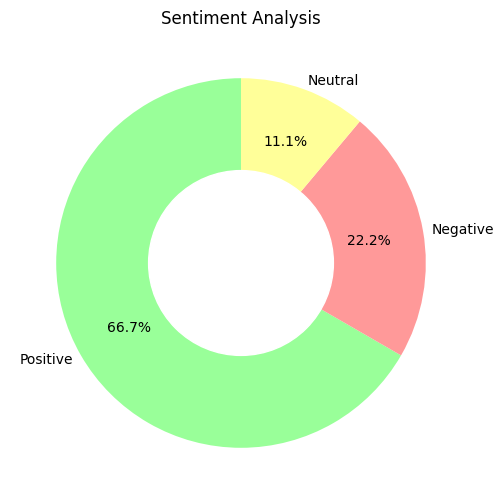

In [81]:
# Plot donut chart of sentiment percentages using Seaborn
labels = ['Positive', 'Negative', 'Neutral']
sizes = [positive, negative, neutral]
colors = ['#99ff99', '#ff9999', '#ffff99']
plt.figure(figsize=(6, 6))
plt.title('Sentiment Analysis')
sns.set_palette(colors)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.7, labeldistance=1.05)
my_circle=plt.Circle((0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()


### Simple code for creating a donut chart (courtesy of chatGPT)

In [82]:
df['Sentiments-TB'] = df['Sentiment']
df.drop(['Sentiment'], axis=1, inplace=True)

In [83]:
print(df)

                                              Review  Sentiments-TB
0  Great customer service, very friendly and help...       0.482500
1  Without a doubt the best indoor shooting range...       0.750000
2  We went to the Randolph location.\nWe went to ...      -0.066667
3  We went to the Randolph location.\nWe went to ...      -0.066667
4  Love this place. Everyone is so helpful, espec...       0.233333
5  The nicest staff ever! We love coming here. Th...       0.350000
6  I have been going to rtsp for quite a while an...       0.344444
7  First time coming here and I called before I c...       0.047222
8  My 2nd time at RTSP and so far so good. They h...       0.190000


In [102]:
# Apply sentiment analysis with NaiveBayesAnalyzer
def get_sentiment_nb(text):
    return TextBlob(text, analyzer=NaiveBayesAnalyzer()).sentiment.p_pos - TextBlob(text, analyzer=NaiveBayesAnalyzer()).sentiment.p_neg

df['Sentiment_NB'] = df['Review'].apply(get_sentiment_nb)

# Calculate sentiment percentages
positive_nb = (df['Sentiment_NB'] > 0.5).sum()
negative_nb = (df['Sentiment_NB'] < 0.45).sum()
neutral_nb = ((df['Sentiment_NB'] <= 0.5) & (df['Sentiment_NB'] >= 0.45)).sum()

# Print sentiment percentages
print('Positive Sentiment (NaiveBayesAnalyzer): {:.2%}'.format(positive_nb/len(df)))
print('Negative Sentiment (NaiveBayesAnalyzer): {:.2%}'.format(negative_nb/len(df)))
print('Neutral Sentiment (NaiveBayesAnalyzer): {:.2%}'.format(neutral_nb/len(df)))

Positive Sentiment (NaiveBayesAnalyzer): 77.78%
Negative Sentiment (NaiveBayesAnalyzer): 11.11%
Neutral Sentiment (NaiveBayesAnalyzer): 11.11%


In [90]:
# Define NLTK stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuations = ['.', ',', ';', ':', '(', ')', '[', ']', '{', '}', '<', '>', '-', '_', '/', '\\', '|', '@', '#', '$', '%', '^', '&', '*', '+', '=', '~', '`', '!', '?']


In [91]:
# Define a function to remove stopwords and punctuation
def clean_text(text):
    # Tokenize the text into words
    words = word_tokenize(text.lower())
    # Remove stopwords and punctuation
    words = [word for word in words if word not in stop_words and word not in punctuations]
    # Join the words back into a string
    cleaned_text = ' '.join(words)
    return cleaned_text


In [92]:
# Apply the clean_text function to the 'Review' column of the dataframe
df['Review'] = df['Review'].apply(clean_text)

In [88]:
df

,Review,Sentiments-TB,Sentiment_NB
0,great customer service friendly helpful highly...,0.482500,0.920581
1,without doubt best indoor shooting range area ...,0.750000,0.453821
2,went randolph location went test guns purchase...,-0.066667,0.622559
3,went randolph location went test guns purchase...,-0.066667,0.622559
4,love place everyone helpful especially beginne...,0.233333,0.411509
5,nicest staff ever love coming range officers r...,0.350000,0.790850
6,going rtsp quite taken training classes extrem...,0.344444,0.799518
7,first time coming called came wife upstate ny ...,0.047222,0.895171
8,2nd time rtsp far good gun selection purchase ...,0.190000,0.725159


In [98]:
# Define a function to generate a word cloud
def generate_wordcloud(text):
    # Tokenize the text into words
    words = word_tokenize(text.lower())
    # Remove stopwords and punctuation
    words = [word for word in words if word not in stop_words and word not in punctuations]
    # Create a dictionary of word frequencies
    freq_dict = {word: words.count(word) for word in words}
    # Generate the word cloud
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate_from_frequencies(freq_dict)
    # Plot the word cloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [99]:
# Get the top 20 words in the 'Review' column
top_words = df['Review'].str.cat(sep=' ').lower().split()
top_words = [word for word in top_words if word not in stop_words and word not in punctuations]
top_words = pd.Series(top_words).value_counts().head(20)

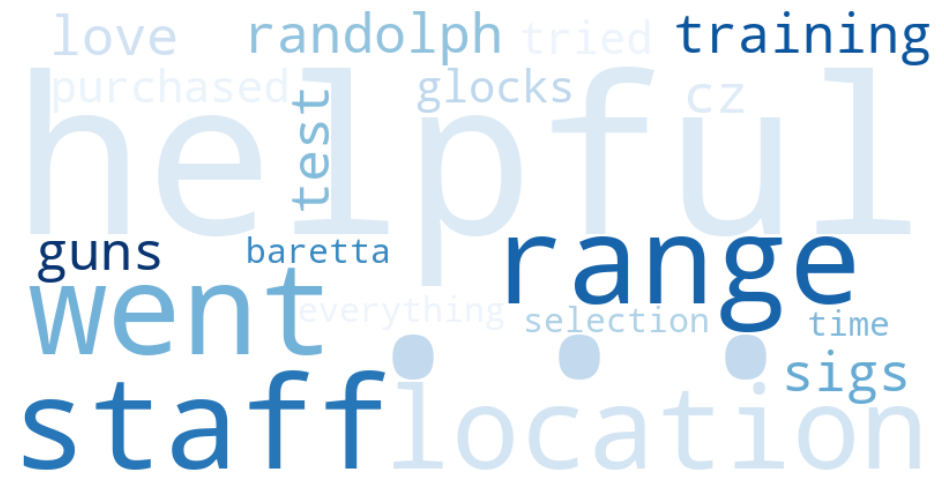

In [100]:
# Generate a word cloud of the top 20 words
generate_wordcloud(' '.join(top_words.index))